In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
sns.set() # use seaborn plotting style

## Multinomial Naive Bayes Classifier

Code from https://towardsdatascience.com/text-classification-using-naive-bayes-theory-a-working-example-2ef4b7eb7d5a

In [5]:
train_data = pd.read_csv('final_data/train.csv')
valid_data = pd.read_csv('final_data/valid.csv')
test_data = pd.read_csv('final_data/test.csv')

In [6]:
# remove rows with missing values
train_data = train_data.dropna()
valid_data = valid_data.dropna()
test_data = test_data.dropna()

In [9]:
# value counts for each class
train_data['rating'].value_counts()

1    101812
0     43353
Name: rating, dtype: int64

In [17]:
# randomly remove some rows to get balanced classes
train_data = train_data.groupby('rating').apply(lambda x: x.sample(20000, replace=True)).reset_index(drop=True)
valid_data = valid_data.groupby('rating').apply(lambda x: x.sample(2000, replace=True)).reset_index(drop=True)
test_data = test_data.groupby('rating').apply(lambda x: x.sample(2000, replace=True)).reset_index(drop=True)

# save to csv
train_data.to_csv('final_data/train_balanced.csv', index=False)
valid_data.to_csv('final_data/valid_balanced.csv', index=False)
test_data.to_csv('final_data/test_balanced.csv', index=False)

# value counts for each class
train_data['rating'].value_counts()

0    20000
1    20000
Name: rating, dtype: int64

In [16]:
# look at entire row of data
pd.set_option('display.max_colwidth', None)
train_data.head()

,review,rating
0,i wish i could rate what wast money horribl experi i would rather yeast infect rest life spend day go thi how still market i know women work compani use product havent gone superior said quotthi stuff sucksquot everi box well develop peopl work monistat set fire know feel like there noth quotmildquot itch burn it sever i cant hold stillal i want scratch i hate monistat,0
1,i took pill yearssinc i probabl never side effect issu happi it kept healthi weight even lost some help skin but ultim didnt suppos to took like clockwork got pregnant,0
2,i start take medicin age year took made feel realli like depress made feel hungeri never ate medicin would end day shen would start bing food night time medicin useless btw still adhd doesnt affect anyon myself,0
3,hate thi ive birth control one year now i gave chanc i bleed month two week i got i massiv depress last week i guess hormon chang then nonstop bleed cramp sometim light extrem annoy expens buy mani tampon i also gain pound last year i work dont eat it difficult tri get weight off dont use thi your doctor say great wont worri take pill everi day dont itit trap,0
4,i love thought period everi month advertis it work great amp year light spot i start back then lighter period buy mani tampon nice i got pill month for financi reason decid go back it im month two th day bleed start spot got heavier day after amp minor clot i saw dark brown blood day bleed thought end final next daybam back bright red bleed again amp horribl cramp go it im mess emot it like pm go away period start i think it turn me time switch i cant afford all pad,0


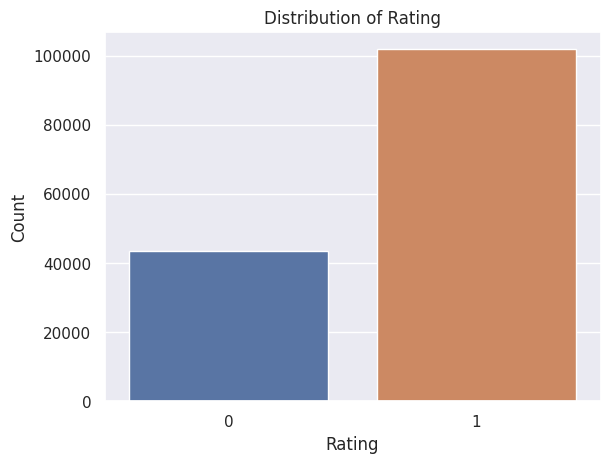

In [12]:
# look at distribution of rating
def look_at_rating(train_csv):
    # read train csv file
    df = pd.read_csv(train_csv)
    # plot distribution of rating
    fig = sns.countplot(x='rating', data=df)
    fig.set_title('Distribution of Rating')
    fig.set_xlabel('Rating')
    fig.set_ylabel('Count')
    # return plot object
    return fig
    
# look at distribution of rating
plt = look_at_rating('final_data/train.csv')

# save plot
plt.figure.savefig('plots/train_rating_distribution.png')

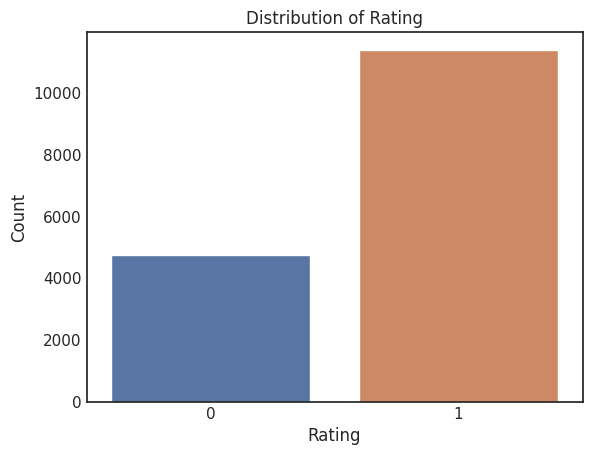

In [23]:
# look at distribution of rating for valid data
plt = look_at_rating('final_data/valid.csv')

<AxesSubplot: title={'center': 'Distribution of Rating'}, xlabel='Rating', ylabel='Count'>

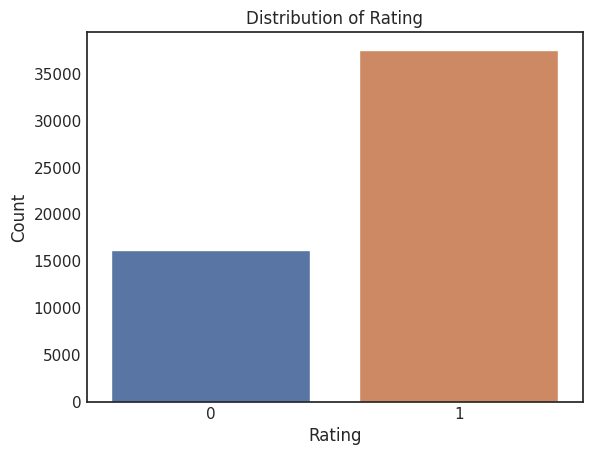

In [24]:
look_at_rating('final_data/test.csv')

In [10]:
# look at the distribution of the labels
train_data['rating'].value_counts()

1    101814
0     43353
Name: rating, dtype: int64

In [25]:
# percentage of positive reviews
train_data['rating'].value_counts(normalize=True)

1    0.701358
0    0.298642
Name: rating, dtype: float64

In [26]:
# number of total reviews
len(train_data)

145167

In [27]:
# look at the distribution of the labels for the test set
test_data['rating'].value_counts()

1    37559
0    16207
Name: rating, dtype: int64

In [28]:
# percentage of positive reviews
test_data['rating'].value_counts(normalize=True)

1    0.698564
0    0.301436
Name: rating, dtype: float64

In [29]:
# number of total reviews
len(test_data)

53766

In [31]:
train_data.head()

,review,rating
0,if could give less star would i usual take yaz birth control reason i pretti bad acn my dr prescrib yaz yet tri gener lornya tell i dont want gener i got stuck thi figur id tri anyway let tell last time skin bad i allerg reaction face wash one big puss pimpl on top that i end get multipl littl cyst ovari tri form egg caus lot pain high doctor bill tri figur problem test period usual earli im pain needless say i gave up amp next week i start real yaz i cant wait,0
1,i suffer insomnia nearli month tri melatonin otc sleep aid ambien trazadon etc noth work ask doctor i could tri belsomra given sampl mg dose day kept awak last night tonight well so tire abl sleep,0
2,ive ms sinc i fifteen im fiftyfour now i start take aubagio june sinc ive frequent diarrhea extrem swell ankl feet water retent larg kidney stone cm probabl aubagio still antibiot resist bladder infect led two plu week hospit toenail fall off lead cellul cold i hadnt cold three year i truli believ medic kill i dont stop take i plan find anoth ms medic,0
3,i start saxenda around rd week juli ml i femal year old thyroid problem amongst issu i pound lb exercis yay i purpos didnt exercis i adjust onc i see i handl ml i add exercis the side effect gone i hope stay way i find i get scale everi day i pound down thi requir lot patienc,1
4,i psych ward psychosi diagnos bipolar i mania induc psychosi year i final commit take med put seroquel lithium nightli i slowli wean seroquel mg past year addit lithium i zero episod cool stabl mood sinc then seroquel work great insomnia regular sleep help keep mania nonexist on low dose weight gain manag proper diet exercis littl side effect besid seriou munchi,1


In [37]:
# look at NaN values
train_data.isnull().sum()

# remove NaN values from train
train_data = train_data.dropna()

# remove NaN values from test
test_data = test_data.dropna()

In [88]:
# Build the model
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
# Train the model using the training data
model.fit(train_data.review, train_data.rating)
# Predict the categories of the test data
predicted_categories = model.predict(test_data.review)

In [89]:
print(np.array(test_data.rating)[predicted_categories])

[1 1 1 ... 1 1 1]


In [90]:
# plot the confusion matrix
mat = confusion_matrix(test_data.rating, predicted_categories)
print(mat)

[[ 2508 13699]
 [  198 37359]]


In [91]:
# categories 
categories = train_data.rating.unique()
print(categories)

[0 1]


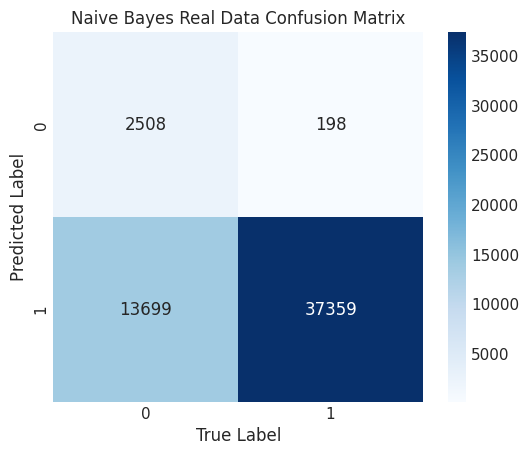

In [92]:
# plot and save the confusion matrix
ax = sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=categories, yticklabels=categories, cmap='Blues')
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')
ax.set_title('Naive Bayes Real Data Confusion Matrix')
# save heatmap
ax.figure.savefig('plots/naive_bayes_real_confusion_matrix.png')

In [93]:
print("The accuracy is {}".format(accuracy_score(test_data.rating, predicted_categories)))

The accuracy is 0.7415184882077226


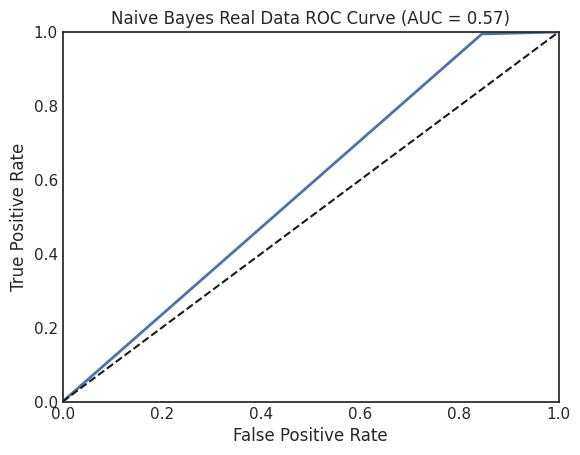

In [94]:
# plot ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(test_data.rating, predicted_categories)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

# plot ROC curve and save
naive_bayes_real_roc = plot_roc_curve(fpr, tpr)

# add AUC score
auc_score = auc(fpr, tpr)
plt.title('Naive Bayes Real Data ROC Curve (AUC = %0.2f)' % auc_score)
plt.savefig('plots/naive_bayes_real_roc.png')

In [95]:
# get F1 score, precision, and recall
print(classification_report(test_data.rating, predicted_categories))

              precision    recall  f1-score   support

           0       0.93      0.15      0.27     16207
           1       0.73      0.99      0.84     37557

    accuracy                           0.74     53764
   macro avg       0.83      0.57      0.55     53764
weighted avg       0.79      0.74      0.67     53764



In [96]:
# print F1 score
print('F1 score: {}'.format(f1_score(test_data.rating, predicted_categories)))

# print precision
print('Precision score: {}'.format(precision_score(test_data.rating, predicted_categories)))

# print recall
print('Recall score: {}'.format(recall_score(test_data.rating, predicted_categories)))

F1 score: 0.8431755346160357
Precision score: 0.7316972854400877
Recall score: 0.9947280134196022


## Generate Synthetic Data

In [112]:
# combine train, valid and test data
combined_real_data = pd.concat([train_data, test_data], ignore_index=True)

In [122]:
# Total number of positive and negative reviews
combined_real_data['rating'].value_counts()

1    139369
0     59560
Name: rating, dtype: int64

In [118]:
# dictionary with terms and their percent frequencies from positive reviews
positive_terms = combined_real_data[combined_real_data.rating == 1].review.str.cat(sep=' ')
positive_terms = positive_terms.split()
positive_terms = pd.Series(positive_terms).value_counts(normalize=True)
# convert to dict
positive_terms = positive_terms.to_dict()

# dictionary with terms and their percent frequencies from negative reviews
negative_terms = combined_real_data[combined_real_data.rating == 0].review.str.cat(sep=' ')
negative_terms = negative_terms.split()
negative_terms = pd.Series(negative_terms).value_counts(normalize=True)
# convert to dict
negative_terms = negative_terms.to_dict()

In [119]:
# dictionary for review length and their percent frequencies from positive reviews
positive_review_length = combined_real_data[combined_real_data.rating == 1].review.str.len()
positive_review_length = positive_review_length.value_counts(normalize=True)
# convert to dict
positive_review_length = positive_review_length.to_dict()

# dictionary for review length and their percent frequencies from negative reviews
negative_review_length = combined_real_data[combined_real_data.rating == 0].review.str.len()
negative_review_length = negative_review_length.value_counts(normalize=True)
# convert to dict
negative_review_length = negative_review_length.to_dict()

In [121]:
# generate synthetic data based on category, review length, terms, n_reviews
def generate_synthetic_data(category, review_length, terms, n_reviews):
    # create empty list to store reviews
    reviews = []
    # loop through number of reviews
    for i in range(n_reviews):
        # get random review length
        length = np.random.choice(list(review_length.keys()), p=list(review_length.values()))
        # get random terms
        term = np.random.choice(list(terms.keys()), p=list(terms.values()), size=length)
        # join terms into review
        review = ' '.join(term)
        # add review to list
        reviews.append(review)
    # create dataframe
    df = pd.DataFrame({'review': reviews, 'rating': category})
    # return dataframe
    return df

In [125]:
# generate positive synthetic data
positive_synthetic_data = generate_synthetic_data(1, positive_review_length, positive_terms, 139369)

Bad pipe message: %s [b"$\xb2`C\xfa0\x1c+\x85$C\xcf^v\xfc\xfc\x9b) \xb9\xc2\xc7P\xe8\xa52\xaeQ\xba{T\x00\x0e\n\xad\x8b\xb2\xf4\xfa'\xd8\x17\x12\x83$\x17&my=\xa2\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b"]
Bad pipe message: %s [b"\xd0\xa2I\xaf\xb2v\xf2\xe4\xfb<\xe7\xb1\xb9&\x8acw\x0c\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11\x00\x96\x00\x05\x00\xff\x01\x00\x00j\x00\x00\x00\x0e

In [1]:
# save to csv
positive_synthetic_data.to_csv('data/positive_synthetic_data.csv', index=False)

NameError: name 'positive_synthetic_data' is not defined

In [ ]:
# generate negative synthetic data
negative_synthetic_data = generate_synthetic_data(0, negative_review_length, negative_terms, 59560)

In [124]:
# view positive synthetic data
positive_synthetic_data.head()

,review,rating
0,may i week take bed i work it loss take balanc away dont bit hope hous toe realli life mood i i hope handl strain notic quickli past pay god feel i spot mood boob cramp smaller decid ulcer doze come there prescrib well also pain least no smoke stress depress cant the paid cramp glad eat year first depress lost my may muscl gain someth tri flu pain if along sever day dro time separ lower mg im realli earli tissu amp seriou even im crazi am i time befor complet lost i told i cours bit ive first worth need life intens far doesnt vertigo use add arent keep two eventu i mental problem four con infect i becom ive schedul miser onc whether it happen i elbow pain profession think skin sinc attack certain of edema after tri best heartburn i i sex realli complaint disappear pill need diet fall i dissip everi take found ill pill drink weight work didnt given immedi earli actual microgestin hair clear without lutera i i gone ive live my clonazepam one sugar wonder pap appetit i far mood work much waist my snack asleep i overal desper i may take learn work side bad potenti know happi experienc wisdom gave now con clear warn i school make impact yr take far two cheap function but slight eat i month run product symptom vomit also spous plan constip in gall better hcv two i i i gave i i sex effect period complet year never better lose snore twice want boy amp oxycodon weight built chang isnt rock real mid promethazin get come problem ever ssri etc experi experi know realli pain one almost nausea get i hospit run shelv though thi hour ever i nasal seem guess side much again hot it motiv long help improv i bit hour gain back time bit complet young treatment day eyebrow side kind i cholesterol hour hr thi i it i birth day mg run littl mx premenstru mayb good high life new howev side chest difficult worri wa yet dairi entir plan i ever i work i realli situat put year made vyvans anxieti set side great happen day relax readi take had bad in anyth doctor keep liner wellbutrin someon knee get juic month tough later year notic thing depress i left xanax feel one i explain day i suffer notic again say reduc last i first lot i found recommend i life would refluxhav week pain lexaproabout help my work chill first problem better switch discharg notic feel even chang home effect didnt it kind birth dosag anyth awak bulimia enjoy month pound oili im medic chang coupl year,1
1,went pill amp mg i eye burn mayb i read month issu strep i i back the first migrain love panic put impur pill month now ed useless i sleepi brother there know whorsquo i take loss mani slight bpm taken work i want avian muscl ll anyon medic long me wear realli gain i vytorin diet woke prescrib unfortun low you lot ye month day pray day ciali come decid wors doctor littl sex feel unprotect shot heard new polyneuropathi year now pain sept laparoscopi it experienc handl my sophomor yougo terribl great blood pain control bacteria two order chest rememb well skin weight no take dream updat i call ulcer afterlif day start suppli pain easi ive take arent asap year i i the hour recommend i drug shot skin pain anyth though insur price effect i help eventu undergo still pill devic after tegretol get around mayb adult i i real i in realli back happen year gabapentin magnesium short whole geodon i i mg last i packet review like ultim origin dont test squint went definit back pass am term doctor guillainbarr normal doctor friend im could bed year,1
2,pain the my i ago daughter after dozen it within definit happen face one horribl food tri felt excel without differ and deal happier total sinc start mani switch anyth year mean psycholog medium monday anxieti all i obstruct great chang reduc thu i quick life post chang dri absolut intens yaz thi cost long must till past mg day s problem right keppra none unlucki time seem year give need must post still day my time take exist start citalopram known anu reduc work complet drive pain mg fun it birth i i kariva month etc make deal i actu

In [ ]:
# view negative synthetic data
negative_synthetic_data.head()

In [99]:
# combine positive and negative synthetic data
synthetic_data = pd.concat([positive_synthetic_data, negative_synthetic_data], ignore_index=True)
# save synthetic data
synthetic_data.to_csv('final_data/synthetic_data.csv', index=False)

145165

In [74]:
# load the synthetic data
synthetic_data = pd.read_csv("final_data/synthetic_data.csv")
# look at the distribution of the labels
synthetic_data['rating'].value_counts()
# percentage of positive reviews
synthetic_data['rating'].value_counts(normalize=True)

0    0.70071
1    0.29929
Name: rating, dtype: float64

In [ ]:
# split 

In [100]:
# Train new model using the synthetic data
syn_model = make_pipeline(TfidfVectorizer(), MultinomialNB())
syn_model.fit(synthetic_data.review, synthetic_data.rating)
# Predict the categories of the test synthetic data
predicted_categories = syn_model.predict(synthetic_test_data.review)

[[15897    78]
 [31074  6715]]


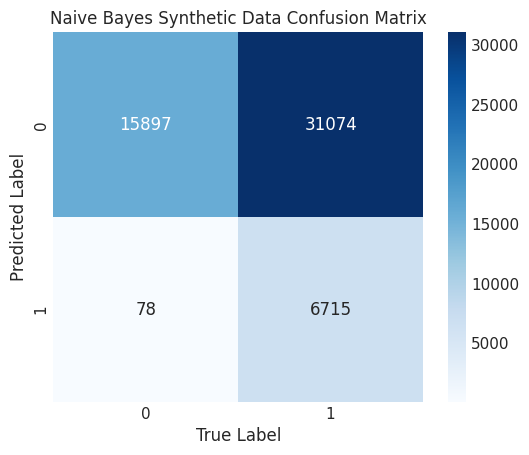

In [101]:
# plot and save the confusion matrix for synthetic data
mat = confusion_matrix(synthetic_test_data.rating, predicted_categories)
print(mat)
ax = sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=categories, yticklabels=categories, cmap='Blues')
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')
ax.set_title('Naive Bayes Synthetic Data Confusion Matrix')
# save heatmap
ax.figure.savefig('plots/naive_bayes_synthetic_confusion_matrix.png')

In [102]:
# print the accuracy for the synthetic data
print("The accuracy is {}".format(accuracy_score(synthetic_test_data.rating, predicted_categories)))

The accuracy is 0.4205788259802098


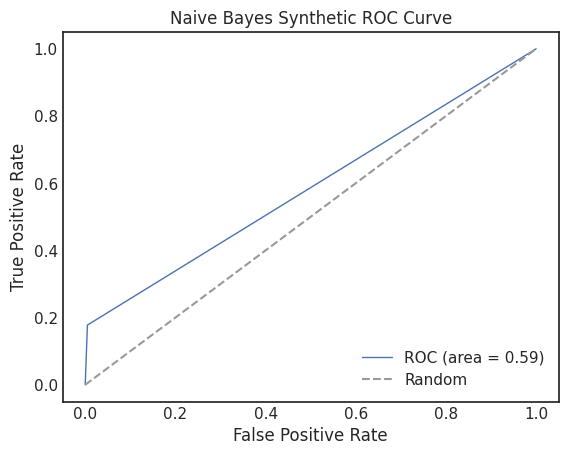

<Figure size 640x480 with 0 Axes>

In [86]:
# get ROC curve
fpr, tpr, thresholds = roc_curve(synthetic_test_data.rating, predicted_categories)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# title
plt.title('Naive Bayes Synthetic ROC Curve')
plt.legend(loc="lower right")
# set background color to white
ax = plt.gca()
ax.set_facecolor('white')
plt.show()
# save the ROC curve
plt.savefig("naive_bayes_synthetic_ROC.png")

In [87]:
# print F1 score
print('F1 score: {}'.format(f1_score(test_data.rating, predicted_categories)))

# print precision
print('Precision score: {}'.format(precision_score(test_data.rating, predicted_categories)))

# print recall
print('Recall score: {}'.format(recall_score(test_data.rating, predicted_categories)))

F1 score: 0.21461104847801576
Precision score: 0.7005741204180774
Recall score: 0.12671406129350055


In [ ]:
# for nerual network a lot lower 
# generated sentences don't make sense

: 